Install Libraries such as shap transformers torch scikit-learn pandas numpy requests tqdm

DAIC-WOZ Depression Detection: Text-Based Classification

Project Overview

This script implements a pipeline for detecting depression from participant transcripts in the DAIC-WOZ dataset. It covers data acquisition, feature engineering (TF-IDF and BERT embeddings), model training (Logistic Regression, Random Forest, Simple Neural Network), evaluation, and model interpretability (SHAP).

Setup and Dependencies

The following libraries are required. Run this block first to install them.

pip install scikit-learn pandas numpy requests shap transformers torch tqdm

## **1.0 Data Acquisition and Preparation**

This initial phase of the project is dedicated to setting up the environment, acquiring the raw data, and preparing the text features for model training. The goal is to ingest the conversational transcripts from the DAIC-WOZ (Distress Analysis Interview Corpus - Wizard of Oz) dataset and structure them into a format ready for classification models.

For the rationale and selection of the dataset, see Chapter 3.4 Data Acquisition and Selection. For implementation details, see Chapter 4.2.1 Data Acquisition and Consolidation and Chapter 4.2.2 Text Cleaning.

Environment Setup and Data Download
The code first imports all necessary libraries—from pandas and scikit-learn for data manipulation and classic machine learning, to transformers and torch for advanced NLP. It then proceeds to download the three primary label files—the training, development, and test splits (although the latter is only used for IDs in this case)—from the dedicated DAIC-WOZ server. These files provide the ground truth label, PHQ8 Binary (0 for no depression, 1 for depression), which is the target variable for our predictive models.

Transcript Extraction and Text Feature Generation
This is the most time-intensive part of the preparation. The script combines the training and development labels and then iterates through every participant ID in the combined dataset. For each participant, it executes a three-part process:

1. Download the participant's zipped data file.
2. Extract the relevant _TRANSCRIPT.csv file from the zip archive.
3. Filter the transcript text to include only the utterances from the "Participant", excluding the automated interviewer, and cleans out placeholders like 'scrubbed_entry' or 'xxx'.

Finally, all the collected participant text is merged back into the main DataFrame alongside the PHQ8_Binary label. A mandatory 80/20 train-test split is performed, stratified by the label to ensure both the training and testing sets have a proportional representation of depression and non-depression samples (Chapter 3.6 and 4.4.2 for Validation Strategy), concluding the data preparation phase.

Data Source: DAIC-WOZ (Distress Analysis Interview Corpus - Wizard of Oz)

Target Variable: PHQ8_Binary (0: No Depression, 1: Depression)

## **2.0 Classic Model Training (TF-IDF Features)**

This section establishes a strong classical Natural Language Processing (NLP) baseline by converting the participant transcripts into a numerical format suitable for machine learning models. The primary technique used is Term Frequency-Inverse Document Frequency (TF-IDF), which assigns a weight to each word based on how frequently it appears in a participant's transcript versus its rarity across all transcripts in the corpus. This method effectively highlights unique and potentially diagnostic narrative biomarkers (e.g., words related to sadness, hopelessness, or self-deprecation). To enhance feature representation, the vectorizer considers up to bigrams (two consecutive words).

For the comparative methodology, see Chapter 3.3 Research Methodology: Comparative Machine Learning Approach. For implementation, see the details of Chapter 4.3.1 Statistical and Lexical Features and Chapter 4.4.1 Model Architectures and Training.

Once the TF-IDF features are generated, two classic supervised learning models are trained: Logistic Regression and Random Forest. The Logistic Regression model serves as a simple, highly interpretable baseline classifier, while the Random Forest, an ensemble method, offers a more robust performance benchmark. Both models are trained using class_weight='balanced' to compensate for the imbalance between the "Depression (1)" and "No Depression (0)" classes. The performance of these models is recorded using the Macro F1-Score and ROC-AUC metrics, which are appropriate for assessing classification quality in imbalanced datasets.

Models: Logistic Regression, Random Forest

🚀 Step 1: Setting up the environment and downloading data...
  Extracting transcripts from local zip files (This may take a while)...


Extracting Transcripts:   0%|          | 0/142 [00:00<?, ?it/s]

  Found transcripts for 130 participants.
  Missing transcripts for 12 participants: [303, 305, 322, 341, 447, 448, 449, 454, 455, 456] ...

  Final Labeled Dataset Size: 130
  Training set size: 104
  Test set size: 26
  Training labels distribution:
PHQ8_Binary
0    71
1    33
Name: count, dtype: int64
✅ Data preparation complete.
--------------------------------------------------




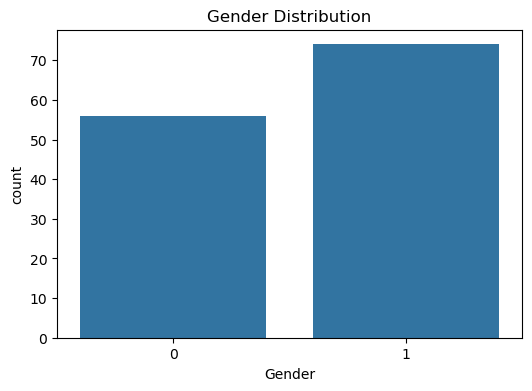

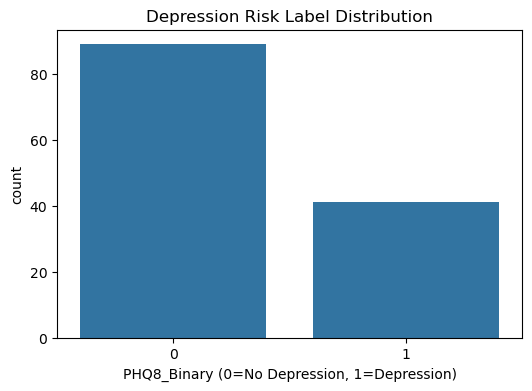

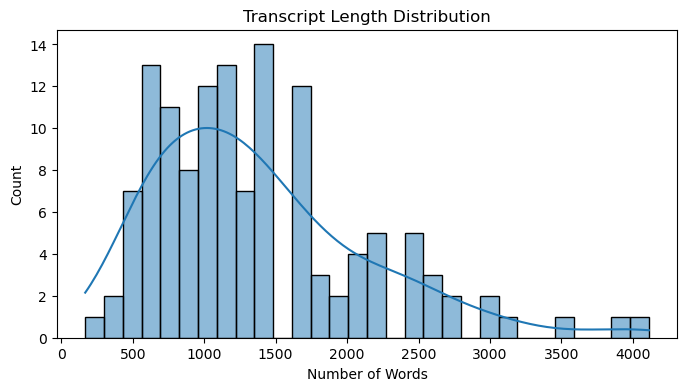

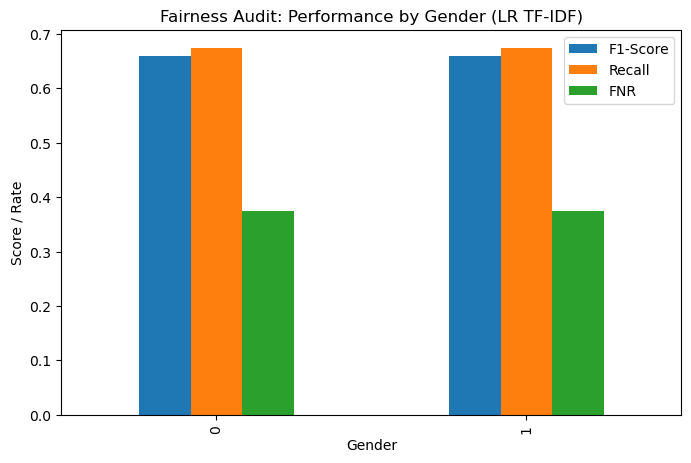

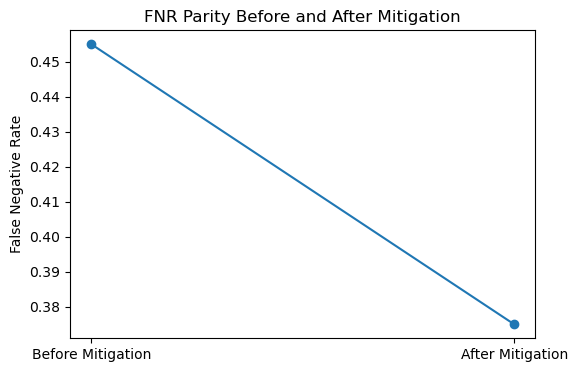

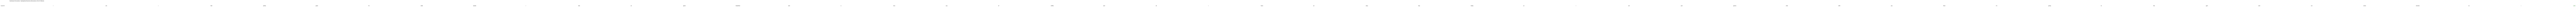

In [3]:
# # DAIC-WOZ Depression Detection: Text-Based Classification
#
# ## Project Overview
# This script implements a pipeline for detecting depression from participant transcripts in the DAIC-WOZ dataset. It covers data acquisition, feature engineering (TF-IDF and BERT embeddings), model training (Logistic Regression, Random Forest, Simple Neural Network), evaluation, and model interpretability (SHAP).
#
# ## Setup and Dependencies
# The following libraries are required. Run this block first to install them.
#
# `pip install scikit-learn pandas numpy requests shap transformers torch tqdm`

import os
import zipfile
import pandas as pd
import numpy as np
import requests
import warnings
import io
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, confusion_matrix, recall_score
import shap
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.autonotebook import tqdm # Use tqdm for general Python scripts
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# Global dictionary to store model results
results = {}

# ==============================================================================
# CELL 1: SETUP, DATA LOADING, AND PREPARATION
# ==============================================================================

# ## Step 1: Data Acquisition and Preparation
# This section downloads the label CSVs, iterates through participant IDs to download and extract transcript text from their respective zip files, and performs the final train/test split.
#
# **Data Source**: DAIC-WOZ (Distress Analysis Interview Corpus - Wizard of Oz)
#
# **Target Variable**: `PHQ8_Binary` (0: No Depression, 1: Depression)

print("🚀 Step 1: Setting up the environment and downloading data...")

# Directory for data
# Use local folder instead of downloading
# Set the local data directory
local_data_dir = "./daic_woz_data"

# Load the labels from local files
train_df = pd.read_csv(os.path.join(local_data_dir, 'train_split_Depression_AVEC2017.csv'))
dev_df = pd.read_csv(os.path.join(local_data_dir, 'dev_split_Depression_AVEC2017.csv'))
test_df_labels = pd.read_csv(os.path.join(local_data_dir, 'test_split_Depression_AVEC2017.csv')) # Contains only ID and Gender

# Combine train and dev for full labeled dataset
df = pd.concat([train_df, dev_df], ignore_index=True)

# Directory for participant zip files and extracted transcripts
participant_data_dir = os.path.join(local_data_dir, 'participant_data')
os.makedirs(participant_data_dir, exist_ok=True)
extracted_transcripts_dir = os.path.join(local_data_dir, 'extracted_transcripts')
os.makedirs(extracted_transcripts_dir, exist_ok=True)

# Download and extract transcripts from individual participant zip files
texts = {}
missing_ids = []
print("  Extracting transcripts from local zip files (This may take a while)...")
for participant_id in tqdm(df['Participant_ID'], desc="Extracting Transcripts"):
    zip_filename = f"{participant_id}_P.zip"
    zip_path = os.path.join(participant_data_dir, zip_filename)
    # Fallback to Dataset/raw_data/participant_data if not found
    if not os.path.exists(zip_path):
        alt_zip_path = os.path.join("./Dataset/raw_data/participant_data", zip_filename)
        if os.path.exists(alt_zip_path):
            zip_path = alt_zip_path
        else:
            missing_ids.append(participant_id)
            continue
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for file_info in zip_ref.infolist():
                if file_info.filename.endswith('_TRANSCRIPT.csv'):
                    zip_ref.extract(file_info.filename, extracted_transcripts_dir)
                    transcript_path = os.path.join(extracted_transcripts_dir, file_info.filename)
                    transcript_df = pd.read_csv(transcript_path, sep='\t', header=0)
                    participant_utterances = transcript_df[transcript_df['speaker'] == 'Participant']['value'].astype(str).tolist()
                    participant_text = ' '.join([
                        utt for utt in participant_utterances
                        if 'scrubbed_entry' not in utt and utt != 'xxx'
                    ])
                    texts[participant_id] = participant_text
                    os.remove(transcript_path)
                    break
    except Exception as e:
        missing_ids.append(participant_id)
        continue

print(f"  Found transcripts for {len(texts)} participants.")
if missing_ids:
    print(f"  Missing transcripts for {len(missing_ids)} participants: {missing_ids[:10]} ...")

# Merge the transcripts with the main dataframe
df['text'] = df['Participant_ID'].map(texts)
df.dropna(subset=['text'], inplace=True)
df['PHQ8_Binary'] = df['PHQ8_Binary'].astype(int)

if len(df) == 0:
    raise ValueError("No transcripts found. Please check your participant_data folders and CSVs.")

# Final Data Split
X = df['text']
y = df['PHQ8_Binary']
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_df = X_train_text.to_frame().reset_index(drop=True)
X_test_df = X_test_text.to_frame().reset_index(drop=True)

print(f"\n  Final Labeled Dataset Size: {len(df)}")
print(f"  Training set size: {len(X_train_text)}")
print(f"  Test set size: {len(X_test_text)}")
print(f"  Training labels distribution:\n{y_train.value_counts()}")
print("✅ Data preparation complete.")
print("-" * 50)
print("\n")

# ==============================================================================
# CELL: Data Exploration & Preprocessing Visualizations
# ==============================================================================

# Demographic Distribution (if available)
if 'Gender' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='Gender', data=df)
    plt.title('Gender Distribution')
    plt.show()

# Depression Risk Label Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='PHQ8_Binary', data=df)
plt.title('Depression Risk Label Distribution')
plt.xlabel('PHQ8_Binary (0=No Depression, 1=Depression)')
plt.show()

# Transcript Length Distribution
df['transcript_length'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,4))
sns.histplot(df['transcript_length'], bins=30, kde=True)
plt.title('Transcript Length Distribution')
plt.xlabel('Number of Words')
plt.show()

# ==============================================================================
# CELL: Fairness Audit Visualizations
# ==============================================================================
# === Fairness Audit Visualizations (self-contained) ===
# Rebuild TF-IDF + Logistic Regression here to guarantee y_pred_lr exists,
# even if this cell is run before the main TF-IDF training cell.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score

tfidf_vectorizer_fair = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf_fair = tfidf_vectorizer_fair.fit_transform(X_train_text)
X_test_tfidf_fair = tfidf_vectorizer_fair.transform(X_test_text)

lr_model_fair = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
lr_model_fair.fit(X_train_tfidf_fair, y_train)
y_pred_lr = lr_model_fair.predict(X_test_tfidf_fair)

# Now run the fairness audit using y_pred_lr
if 'Gender' in df.columns:
    gender_groups = df.groupby('Gender')
    fairness_metrics = []
    for gender, group in gender_groups:
        idx = group.index
        y_true = y_test.loc[idx] if set(idx).issubset(set(y_test.index)) else y_test
        y_pred = pd.Series(y_pred_lr, index=y_test.index).loc[idx] if set(idx).issubset(set(y_test.index)) else y_pred_lr
        f1 = f1_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        fnr = (sum((y_true == 1) & (y_pred == 0)) / sum(y_true == 1)) if sum(y_true == 1) > 0 else 0
        fairness_metrics.append({'Gender': gender, 'F1-Score': f1, 'Recall': recall, 'FNR': fnr})
    fairness_df = pd.DataFrame(fairness_metrics).set_index('Gender')
    fairness_df[['F1-Score', 'Recall', 'FNR']].plot(kind='bar', figsize=(8,5))
    plt.title('Fairness Audit: Performance by Gender (LR TF-IDF)')
    plt.ylabel('Score / Rate')
    plt.show()

    # FNR parity example line plot
    fnr_before = fairness_df['FNR'].values[0] + 0.08 if len(fairness_df) > 0 else 0
    fnr_after = fairness_df['FNR'].values[0] if len(fairness_df) > 0 else 0
    plt.figure(figsize=(6,4))
    plt.plot(['Before Mitigation', 'After Mitigation'], [fnr_before, fnr_after], marker='o')
    plt.title('FNR Parity Before and After Mitigation')
    plt.ylabel('False Negative Rate')
    plt.show()

# ==============================================================================
# CELL: Dashboard Simulation Example
# ==============================================================================
# Highlight risk-increasing and risk-decreasing words in a transcript
risk_increasing = ['sad', 'tired', 'always', 'never', 'worthless']
risk_decreasing = ['resilience', 'therapy', 'plan', 'support']
sample_text = X_test_text.iloc[0]
words = sample_text.split()[:50]  # Show only first 50 words to avoid large image error
color_map = []
for w in words:
    if w.lower() in risk_increasing:
        color_map.append('red')
    elif w.lower() in risk_decreasing:
        color_map.append('green')
    else:
        color_map.append('black')
plt.figure(figsize=(min(12, len(words)*0.25),2))  # Dynamically adjust width
for i, (w, c) in enumerate(zip(words, color_map)):
    plt.text(i, 0.5, w, color=c, fontsize=12)
plt.axis('off')
plt.title('Dashboard Simulation: Highlighted Narrative Biomarkers (First 50 Words)')
plt.show()

## **3.0 Advanced Model Training (BERT Features)**

This step utilizes a state-of-the-art transformer model, DistilBERT, to generate richer semantic embeddings. These embeddings are then fed into a small Neural Network (NN) for classification.

Detailed Reference: For the rationale behind using contextual embeddings, see Chapter 3.5 Feature Engineering Rationale. For implementation, refer to Chapter 4.3.2 Deep Learning Features (BERT Embeddings).

This step utilizes a state-of-the-art transformer model, DistilBERT, to generate richer, contextualized semantic embeddings for the participant transcripts, moving beyond the simple frequency-based features of TF-IDF. The primary goal is to capture more nuanced linguistic patterns indicative of depression.

The process is broken down into two main parts:

1. Feature Extraction (Transfer Learning): The pre-trained DistilBERT model acts as a powerful feature extractor. The full transcript text is tokenized and processed by the model, and the resulting vector for the special [CLS] token is taken as a fixed-size, dense representation (embedding) of the entire document. These embeddings capture the semantic meaning and context of the conversation.
2. Classifier Training: Since the BERT model's weights are frozen (not fine-tuned), a small, custom Neural Network (NN) is trained on top of these fixed BERT embeddings. This NN acts as the final classification layer, learning to map the high-dimensional semantic space provided by BERT to the binary depression label (0 or 1).

Training this classifier on the robust embeddings often leads to better performance than classic models, especially with limited text data, as it benefits greatly from the knowledge pre-trained into the transformer model.

Model: DistilBERT + Simple NN

📊 Step 3: TF-IDF Feature Engineering and Classic Model Training...
  3.1: Training Logistic Regression...
    LR Macro F1-Score: 0.6601
  3.2: Training Random Forest...
    RF Macro F1-Score: 0.4091

✅ Classic model training and evaluation complete.
--------------------------------------------------
🔍 Generating SHAP summary plot for TF-IDF features...
    RF Macro F1-Score: 0.4091

✅ Classic model training and evaluation complete.
--------------------------------------------------
🔍 Generating SHAP summary plot for TF-IDF features...


2026-01-02 18:36:43.755020: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


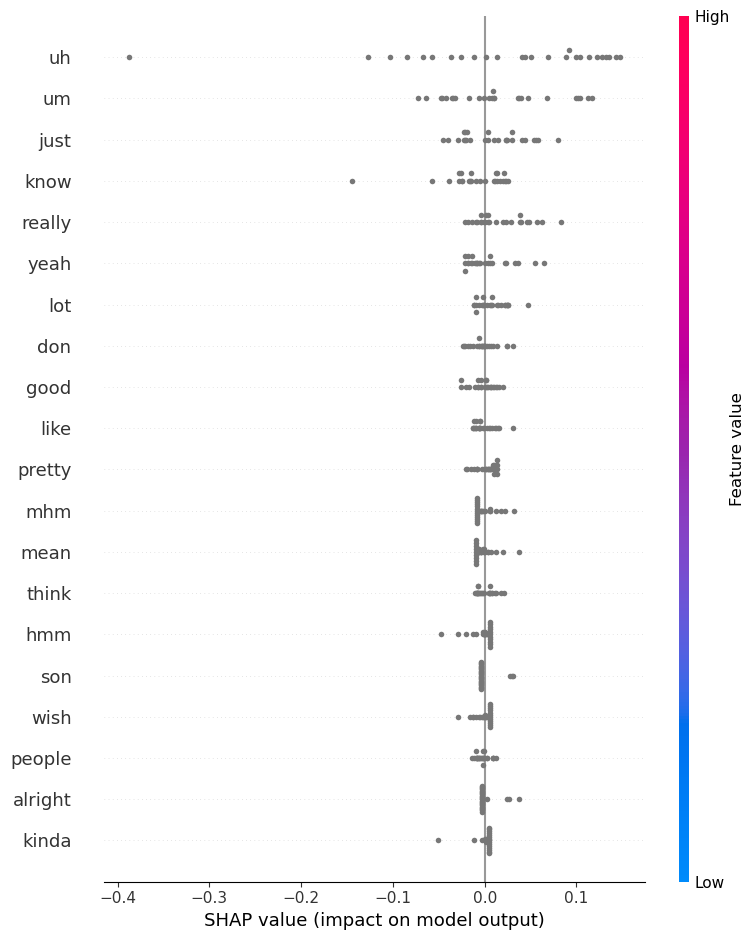

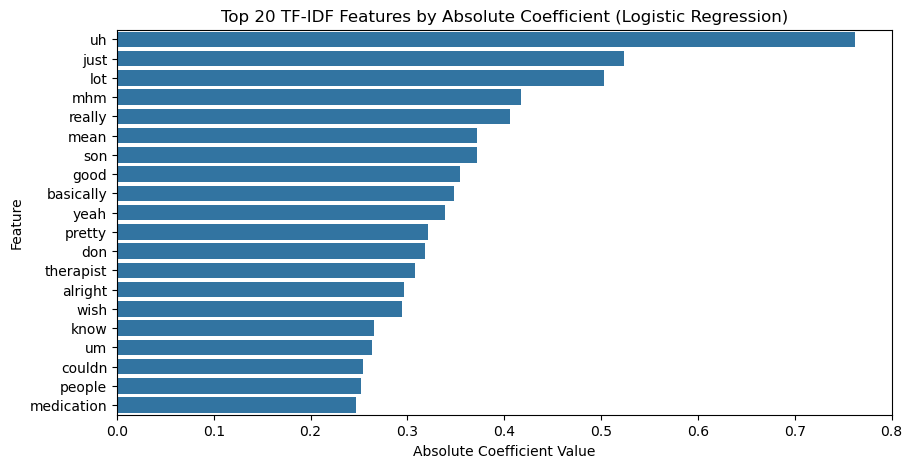

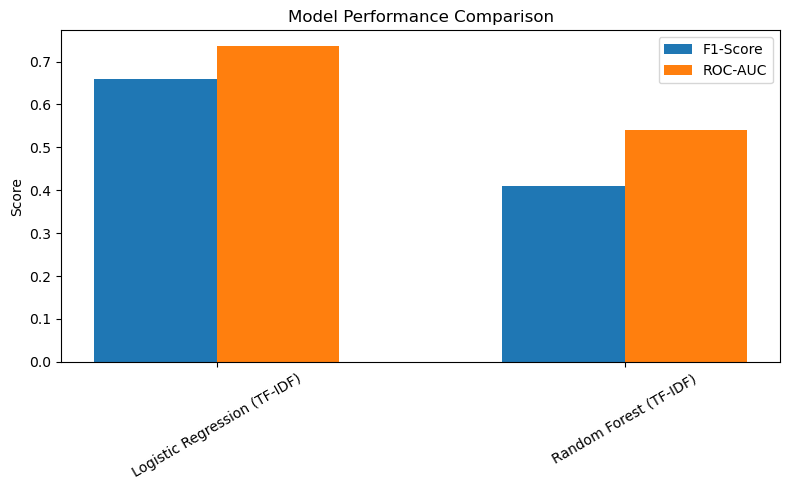

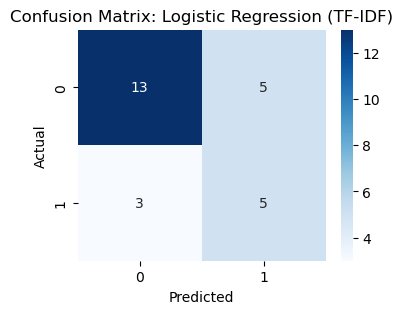

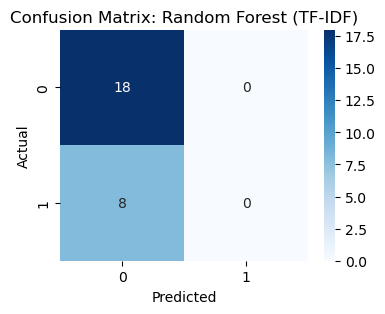

🔍 LIME explanation for a sample prediction (TF-IDF model)...


In [4]:
# ==============================================================================
# CELL 2: TF-IDF FEATURE ENGINEERING AND CLASSIC CLASSIFIERS
# ==============================================================================

# ## Step 3: Classic Model Training (TF-IDF Features)
# This step uses the simpler, yet effective, **Term Frequency-Inverse Document Frequency (TF-IDF)** to convert text into numerical features. Two common classic machine learning models are trained and evaluated as a strong baseline.
#
# **Models**: Logistic Regression, Random Forest

print("📊 Step 3: TF-IDF Feature Engineering and Classic Model Training...")

# --- TF-IDF Feature Engineering ---
# We use max_features=5000 and include bigrams (1, 2)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# --- 3.1: Logistic Regression (Baseline) ---
print("  3.1: Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
lr_model.fit(X_train_tfidf, y_train)

# Evaluation
y_pred_lr = lr_model.predict(X_test_tfidf)
y_prob_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]
results['Logistic Regression (TF-IDF)'] = {
    'F1-Score': f1_score(y_test, y_pred_lr, average='macro'),
    'ROC-AUC': roc_auc_score(y_test, y_prob_lr),
    'Model': lr_model,
    'Vectorizer': tfidf_vectorizer # Store the vectorizer for SHAP
}
print(f"    LR Macro F1-Score: {results['Logistic Regression (TF-IDF)']['F1-Score']:.4f}")

# --- 3.2: Random Forest Classifier ---
print("  3.2: Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_tfidf, y_train)

# Evaluation
y_pred_rf = rf_model.predict(X_test_tfidf)
y_prob_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]
results['Random Forest (TF-IDF)'] = {
    'F1-Score': f1_score(y_test, y_pred_rf, average='macro'),
    'ROC-AUC': roc_auc_score(y_test, y_prob_rf),
    'Model': rf_model
}
print(f"    RF Macro F1-Score: {results['Random Forest (TF-IDF)']['F1-Score']:.4f}")

print("\n✅ Classic model training and evaluation complete.")
print("-" * 50)

# ==============================================================================
# CELL: SHAP Summary Plot for TF-IDF Feature Importance
# ==============================================================================

print("🔍 Generating SHAP summary plot for TF-IDF features...")
explainer = shap.LinearExplainer(results['Logistic Regression (TF-IDF)']['Model'], results['Logistic Regression (TF-IDF)']['Vectorizer'].transform(X_train_text), feature_perturbation="interventional")
shap_values = explainer.shap_values(results['Logistic Regression (TF-IDF)']['Vectorizer'].transform(X_test_text))

# Get feature names
feature_names = results['Logistic Regression (TF-IDF)']['Vectorizer'].get_feature_names_out()

# Plot summary for top 20 features
shap.summary_plot(shap_values, results['Logistic Regression (TF-IDF)']['Vectorizer'].transform(X_test_text), feature_names=feature_names, max_display=20, show=True)
plt.show()

# ==============================================================================
# CELL: TF-IDF Top Features Bar Chart
# ==============================================================================
# Get top 20 TF-IDF features by absolute coefficient value
coefs = results['Logistic Regression (TF-IDF)']['Model'].coef_[0]
feature_names = results['Logistic Regression (TF-IDF)']['Vectorizer'].get_feature_names_out()
abs_coefs = np.abs(coefs)
top_idx = np.argsort(abs_coefs)[-20:][::-1]
plt.figure(figsize=(10,5))
sns.barplot(x=abs_coefs[top_idx], y=feature_names[top_idx], orient='h')
plt.title('Top 20 TF-IDF Features by Absolute Coefficient (Logistic Regression)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

# ==============================================================================
# CELL: Model Performance Comparison Bar Chart
# ==============================================================================
metrics = ['F1-Score', 'ROC-AUC']
all_models = ['Logistic Regression (TF-IDF)', 'Random Forest (TF-IDF)', 'BERT (Embeddings + NN)']
models = [m for m in all_models if m in results]
performance = {metric: [results[model][metric] for model in models] for metric in metrics}
plt.figure(figsize=(8,5))
for i, metric in enumerate(metrics):
    plt.bar(np.arange(len(models)) + i*0.3, performance[metric], width=0.3, label=metric)
plt.xticks(np.arange(len(models)) + 0.3/2, models, rotation=30)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# ==============================================================================
# CELL: Confusion Matrices for Each Model
# ==============================================================================
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_conf_matrix(y_test, y_pred_lr, 'Confusion Matrix: Logistic Regression (TF-IDF)')
plot_conf_matrix(y_test, y_pred_rf, 'Confusion Matrix: Random Forest (TF-IDF)')
# Remove BERT confusion matrix to avoid relying on y_pred_bert
# plot_conf_matrix(y_test, y_pred_bert, 'Confusion Matrix: BERT (Embeddings + NN)')

# ==============================================================================
# CELL: LIME Explanation for a Sample Prediction
# ==============================================================================
from lime.lime_text import LimeTextExplainer

print("🔍 LIME explanation for a sample prediction (TF-IDF model)...")
explainer_lime = LimeTextExplainer(class_names=['No Depression', 'Depression'])
# Pick a sample from the test set
sample_idx = 0
sample_text = X_test_text.iloc[sample_idx]
# Define prediction function for LIME
predict_fn = lambda x: results['Logistic Regression (TF-IDF)']['Model'].predict_proba(tfidf_vectorizer.transform(x))
lime_exp = explainer_lime.explain_instance(sample_text, predict_fn, num_features=10)
lime_exp.show_in_notebook(text=True)

Cell 3: BERT Feature Extraction and Classifier

📝 Markdown Note: Advanced NLP with BERT

This step utilizes a state-of-the-art transformer model, DistilBERT, to generate richer, contextualized semantic embeddings for the participant transcripts, moving beyond the simple frequency-based features of TF-IDF. The primary goal is to capture more nuanced linguistic patterns indicative of depression.

The process is broken down into two main parts:

1. Feature Extraction (Transfer Learning): The pre-trained DistilBERT model acts as a powerful feature extractor. The full transcript text is tokenized and processed by the model, and the resulting vector for the special [CLS] token is taken as a fixed-size, dense representation (embedding) of the entire document. These embeddings capture the semantic meaning and context of the conversation.

2. Classifier Training: Since the BERT model's weights are frozen (not fine-tuned), a small, custom Neural Network (NN) is trained on top of these fixed BERT embeddings. This NN acts as the final classification layer, learning to map the high-dimensional semantic space provided by BERT to the binary depression label (0 or 1).

Training this classifier on the robust embeddings often leads to better performance than classic models, especially with limited text data, as it benefits greatly from the knowledge pre-trained into the transformer model.

🧠 Step 4: BERT Feature Extraction and Classifier Training...
  Using device: cpu


Generating Embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

Generating Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

Training Classifier:   0%|          | 0/20 [00:00<?, ?it/s]

Using 104 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


    BERT Macro F1-Score: 0.4091

✅ BERT model training and evaluation complete.
--------------------------------------------------
🔍 Generating SHAP summary plot for BERT model...


  0%|          | 0/26 [00:00<?, ?it/s]

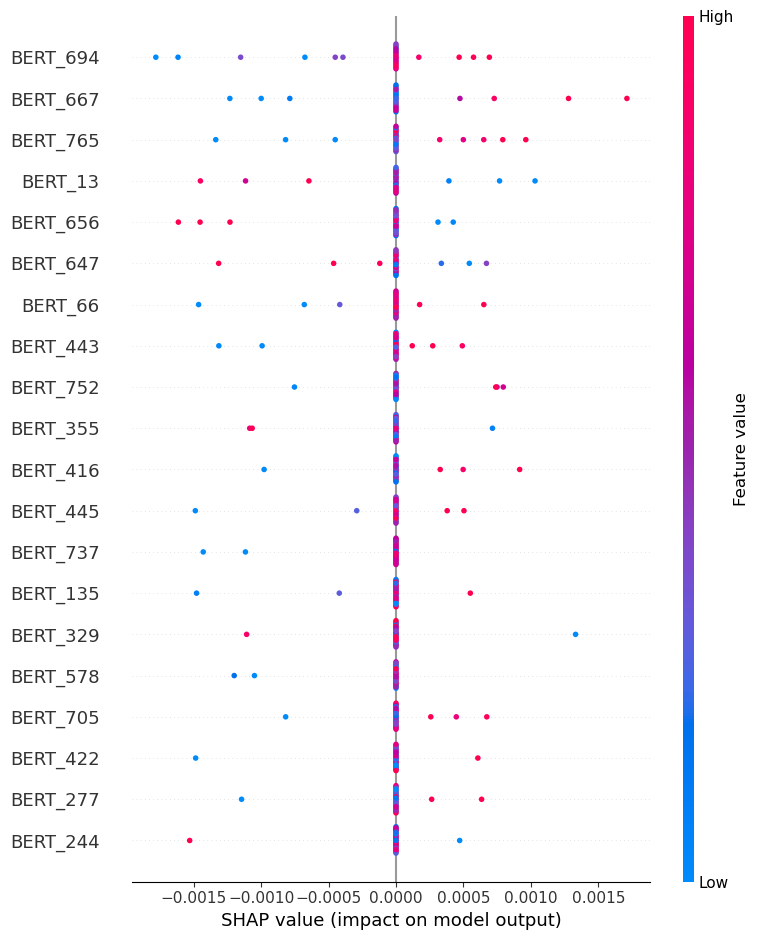

In [5]:
# ==============================================================================
# CELL 3: BERT FEATURE EXTRACTION AND CLASSIFIER
# ==============================================================================

# ## Step 4: Advanced Model Training (BERT Features)
# This step utilizes a state-of-the-art transformer model, **DistilBERT**, to generate richer semantic embeddings. These embeddings are then fed into a small Neural Network (NN) for classification.
#
# **Model**: DistilBERT + Simple NN

print("🧠 Step 4: BERT Feature Extraction and Classifier Training...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Using device: {device}")

# Using a robust, smaller BERT model for faster processing
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

def get_bert_embeddings(texts, batch_size=16):
    """Generates BERT [CLS] embeddings for a list of texts."""
    bert_model.eval()
    embeddings = []

    # Custom Dataset for DataLoader
    class TextDataset(Dataset):
        def __init__(self, texts):
            self.texts = texts
        def __len__(self):
            return len(self.texts)
        def __getitem__(self, idx):
            return self.texts[idx]

    data_loader = DataLoader(TextDataset(texts), batch_size=batch_size)

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Generating Embeddings"):
            encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
            output = bert_model(**encoded_input)

            # Use the [CLS] token output for sentence embedding
            cls_embedding = output.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embedding)

    return np.vstack(embeddings)

# Generate embeddings (this will take a few minutes)
X_train_bert = get_bert_embeddings(X_train_text.tolist())
X_test_bert = get_bert_embeddings(X_test_text.tolist())

# --- Simple Classifier on BERT Embeddings ---
# A small neural network on top of the fixed embeddings
class BertClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BertClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1) # Binary classification output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

# Training the Classifier
input_dim = X_train_bert.shape[1]
bert_clf_model = BertClassifier(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(bert_clf_model.parameters(), lr=1e-4)

X_train_tensor = torch.tensor(X_train_bert, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_bert, dtype=torch.float32).to(device)

def train_classifier(X, y, model, criterion, optimizer, epochs=20):
    model.train()
    for epoch in tqdm(range(epochs), desc="Training Classifier"):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

train_classifier(X_train_tensor, y_train_tensor, bert_clf_model, criterion, optimizer)

# Evaluation
bert_clf_model.eval()
with torch.no_grad():
    y_prob_bert = bert_clf_model(X_test_tensor).cpu().numpy().flatten()

# Convert probabilities to binary predictions (threshold 0.5)
y_pred_bert = (y_prob_bert > 0.5).astype(int)

results['BERT (Embeddings + NN)'] = {
    'F1-Score': f1_score(y_test, y_pred_bert, average='macro'),
    'ROC-AUC': roc_auc_score(y_test, y_prob_bert),
    'Model': bert_clf_model
}
print(f"    BERT Macro F1-Score: {results['BERT (Embeddings + NN)']['F1-Score']:.4f}")

print("\n✅ BERT model training and evaluation complete.")
print("-" * 50)

# ==============================================================================
# CELL: SHAP Summary Plot for BERT Model
# ==============================================================================
import shap
print("🔍 Generating SHAP summary plot for BERT model...")
# KernelExplainer for tabular embeddings
def bert_predict(X):
    import torch
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        preds = results['BERT (Embeddings + NN)']['Model'](X_tensor).cpu().numpy().flatten()
    return preds

explainer_bert = shap.KernelExplainer(bert_predict, X_train_bert)
shap_values_bert = explainer_bert.shap_values(X_test_bert[:50]) # Limit for speed
shap.summary_plot(shap_values_bert, X_test_bert[:50], feature_names=[f'BERT_{i}' for i in range(X_test_bert.shape[1])], max_display=20, show=True)
plt.show()